### Lesson 1: Mananging Message History

#### Messages

First, let's briefly review `messages`, which re-enforces what we learned in Module 1.

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) take a set of [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as inputs, and return a `message` as output. 

Chat models support the assignment of distinct roles to conversation messages. 

Let's create a list of messages with different roles:

* `AIMessage` represents a message from an AI assistant
* `HumanMessage` represents a message from a human user

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph langchain_openai langchain_anthropic

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

In [36]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?")]
messages.extend([HumanMessage(f"Yes, I know about whales. But what others should I learn about?")])

We can pass this to a Chat model, and it responds with an `AIMessage`.

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Great to hear that you\'re interested in ocean mammals! Besides whales, there are several other fascinating marine mammals you might want to explore:\n\n### Dolphins\n- **Bottlenose Dolphins**: Known for their intelligence and playful behavior.\n- **Orcas (Killer Whales)**: Actually a type of dolphin, these apex predators are highly social and have complex hunting strategies.\n\n### Seals and Sea Lions\n- **Harbor Seals**: Common in coastal areas, known for their spotted coats.\n- **California Sea Lions**: Recognizable by their external ear flaps and barking sounds.\n- **Walrus**: Notable for their long tusks and large size.\n\n### Manatees and Dugongs\n- **West Indian Manatee**: Often referred to as "sea cows," these gentle giants are found in warm coastal waters.\n- **Dugong**: Similar to manatees but with a fluked tail, they inhabit the coastal waters of the Indian and Pacific Oceans.\n\n### Otters\n- **Sea Otters**: Known for their dense fur and use of tools to o

As discussed in Module 1, we can use messages in our Graph as the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#working-with-messages-in-graph-state).

* We use a `TypedDict` with a single key `messages`, which is a list of `AnyMessage` objects. 
* The `Annotated` type is used with `add_messages`, which [is a reducer function](https://langchain-ai.github.io/langgraph/concepts/low_level/#using-messages-in-your-graph).
* Reducers determine how updates are applied to the state.
* The `add_messages` reducer will append new messages to the existing list.

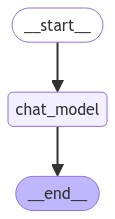

In [37]:
from typing import Annotated, List, TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# State
class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages = graph.invoke({'messages': messages})

Notice now we return the chat model output:

```
return {"messages": [llm.invoke(state["messages"])]}
```

This line is crucial for appending the chat model output to our state:

* `llm.invoke(state["messages"])` generates a new message from the language model based on the conversation history.
* The message is returned in a dictionary with the key "messages".
* When this dictionary is returned from the node, LangGraph applies it as an update to the state.
* We used the `add_messages` reducer in our state definition.
* The reducer means that the new message is appended to the existing list of messages in the state, rather than replacing it.

In [39]:
messages['messages']

[AIMessage(content='So you said you were researching ocean mammals?', id='67838cd9-f2a7-4f8b-b4e1-2c0244a3fd2c'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', id='8a1f6637-2e4a-4546-97ff-02e215786cd7'),
 AIMessage(content='That\'s great that you know about whales! There\'s a fascinating variety of ocean mammals you can learn about. Here are a few others you might find interesting:\n\n1. **Dolphins**: Closely related to whales, dolphins are highly intelligent and social animals. They are known for their playful behavior and complex communication skills.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical characteristics, such as a more rounded snout and spade-shaped teeth.\n\n3. **Seals**: There are two main types of seals: earless seals (true seals) and eared seals (which include sea lions and fur seals). They are adapted to life both in the water and on land.\n\n4. **Sea Lions**: These are par

#### Filtering messages

As conversations get longer, they consume more tokens. 

This can often be undesirable as it leads to more expensive and longer calls to the LLM.

Of course, messages are simply a list that can be [filtered easily](https://langchain-ai.github.io/langgraph/how-tos/memory/manage-conversation-history/#filtering-messages).

In [28]:
messages['messages'][0]

AIMessage(content='So you said you were researching ocean mammals?', id='b24fec42-91e6-4ac9-a71b-4dca10026ba7')

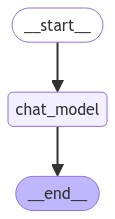

In [30]:
# State
class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]

def filter_messages(messages: list):
    # This is a simple helper function which only ever uses the last two messages
    return messages[-1:]

# Node
def chat_model_node(state: MessagesState):
    messages = filter_messages(state["messages"])
    return {"messages": llm.invoke(messages)}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# Create a new list of mesages
messages = [AIMessage(f"So you said you were researching ocean mammals?")]
messages.extend([HumanMessage(f"Yes, that's right.")])
messages.extend([AIMessage(f"Great, what would you like to learn about.")])
messages.extend([HumanMessage(f"I want to learn about the best place to see Orcas on the West Coast of the United States.")])

In [32]:
# Invoke, using message filtering
messages_out = graph.invoke({'messages': messages})

We can see that the chat model call uses a [filtered history of 2 messages](https://smith.langchain.com/public/5863928c-1ec4-42d3-898e-eaee4fcfec11/r).

#### Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

In [ ]:
from langchain_core.messages import trim_messages

# State
class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]

def trim_messages(messages: list):
    return trim_messages(
        messages,
        max_tokens=250,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o"),
    )

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(state["messages"])
    return {"messages": llm.invoke(messages)}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
# Invoke, using message trimming
messages_out = graph.invoke({'messages': messages})

Again, we can look at the [trace](https://smith.langchain.com/public/314dd5b2-77ee-4426-a1c2-21a3db398c77/r) to see how many messages are passed given our trim specification.

### Lesson 2: Message Summarization

Another useful trick is to [create a summary](https://langchain-ai.github.io/langgraph/how-tos/memory/add-summary-conversation-history/) of the conversation to date, and use that with the past N messages.

In [47]:
# We will use this model for both the conversation and the summarization
model = ChatAnthropic(model_name="claude-3-haiku-20240307")

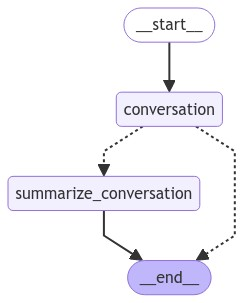

In [58]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import SystemMessage, RemoveMessage

class State(MessagesState):
    summary: str
    messages: Annotated[list[AnyMessage], add_messages]

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

def summarize_conversation(state: State):
    
    # First, we summarize the conversation
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # If a summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Add our summary to the state 
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Define a new graph
workflow = StateGraph(State)

# Define the conversation node and the summarize node
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")

# We now add a conditional edge
workflow.add_conditional_edges("conversation", should_continue)

# We now add a normal edge from `summarize_conversation` to END.
workflow.add_edge("summarize_conversation", END)

# Compile
memory = SqliteSaver.from_conn_string(":memory:")
graph = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))

As before, we can use a [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

This creates a temporary in-memory database.    

The checkpointer allows us to create  "threads" of conversation, where each thread maintains its own state.

In [46]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="i like the 49ers!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi there! It's nice to meet you Lance. I'm Claude, an AI assistant created by Anthropic. How can I help you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance, as you introduced yourself at the start of our conversation.
================================ Human Message =================================

i like the 49ers!
================================== Ai Message ==================================

That's great, the 49ers are a popular NFL team. Do you follow them closely? Who are some of your favorite players on the team?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

We can pick up the conversation because we have the thread.

In [50]:
app.get_state(config).values.get("summary","")

''

As we continue, we see that summarization are done, older messages are removed, and we proceed. 

In [51]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like Nick Bosa, isn't he the highest paid defensive player?
================================== Ai Message ==================================

You're right, Nick Bosa is currently the highest paid defensive player in the NFL. In 2022, he signed a record-breaking 5-year, $141 million contract extension with the 49ers, making him the highest paid non-quarterback in the league.

Bosa is an incredibly talented and dominant defensive end for the 49ers. He was the 2nd overall pick in the 2019 NFL Draft and has quickly established himself as one of the best pass rushers in the game. In 2022, he recorded 18.5 sacks, 49 tackles, and 19 tackles for loss, helping lead the 49ers' defense.

It's great to hear you're a fan of Bosa and the 49ers. He's certainly one of the most impactful and well-compensated defensive players in the NFL right now. Let me know if you have any other thoughts on the 49ers or the NFL in gen

/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [52]:
app.get_state(config).values.get("summary","")

"Here is a summary of the conversation so far:\n\nThe conversation started with me, the AI assistant Claude, greeting the human and introducing myself. The human then asked me what their name was, and I correctly identified their name as Lance.\n\nThe human then mentioned that they like the San Francisco 49ers NFL team. I responded positively and asked if they follow the team closely. The human then brought up that they like 49ers player Nick Bosa, and noted that Bosa is currently the highest paid defensive player in the NFL.\n\nI confirmed that this is accurate, explaining that Bosa recently signed a record-breaking 5-year, $141 million contract extension with the 49ers, making him the highest paid non-quarterback in the league. I also highlighted some of Bosa's impressive stats and performance from the 2022 season.\n\nOverall, the conversation so far has centered around the human's fandom of the 49ers, particularly their admiration for star defensive player Nick Bosa and his new lucr

In [53]:
input_message = HumanMessage(content="i also like CMC. when did he join the 49ers, again?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i also like CMC. when did he join the 49ers, again?
================================== Ai Message ==================================

You're talking about Christian McCaffrey, the star running back who was recently traded to the San Francisco 49ers. However, McCaffrey did not join the 49ers in 2022 - he was actually traded to the 49ers midway through the 2022 season.

The trade happened on October 20, 2022, when the 49ers acquired McCaffrey from the Carolina Panthers in exchange for a haul of draft picks, including a 2023 second-round pick, a 2023 third-round pick, a 2023 fourth-round pick and a 2024 fifth-round pick.

McCaffrey had spent his entire NFL career with the Panthers since being drafted 8th overall in 2017. But the 49ers saw him as a perfect fit for their offense and were willing to give up significant draft capital to bring him in as a dynamic weapon alongside players like Deebo Samuel and Geo

### Lesson 3: Saving to an external DB

Above, we were using a [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

When we supply `":memory:"` it creates an in-memory DB.

If we supply the path to a sqlite DB, then a DB will be created to persist the state.

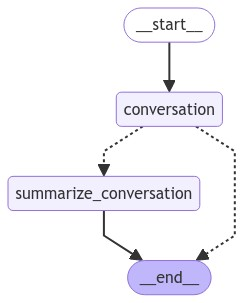

In [68]:
# Compile
db_path = "/Users/rlm/Desktop/example.db"
memory = SqliteSaver.from_conn_string(db_path)
graph = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))

In [69]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="i like the 49ers!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance, it's nice to meet you! How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

You said your name is Lance.
================================ Human Message =================================

i like the 49ers!
================================== Ai Message ==================================

Okay, got it - you like the 49ers football team. The 49ers are a professional American football team based in the San Francisco Bay Area. They play in the National Football League (NFL) and have had a lot of success over the years, winning 5 Super Bowl championships. It's great that you're a fan of theirs!


In [ ]:
%%capture --no-stderr
%pip install --quiet -U sqlite3

In [80]:
import sqlite3

def dump_db_contents(cursor):
    
    # Retrieve the names of all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    if not tables:
        print("No tables found in the database.")
    else:
        for table in tables:
            table_name = table[0]
            print(f"Table: {table_name}")
            
            # Fetch and print all data from the table
            cursor.execute(f"SELECT * FROM {table_name}")
            rows = cursor.fetchall()
            
            # Get column names
            cursor.execute(f"PRAGMA table_info({table_name})")
            columns = [desc[1] for desc in cursor.fetchall()]
            
            print(f"Columns: {', '.join(columns)}")
            
            for row in rows:
                print(row)
            print()
            
# Dump the database contents
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

dump_db_contents(cursor)

# Close the connection
conn.close()

No tables found in the database.


Also, show the postgres lib.

```
pip installable library with postgres checkpointer
```